# samsung dataset
Train Dataset (학습용 데이터셋, 학습 가능) - 총 60664개 SEM [폴더] : 실제 SEM 영상을 Hole 단위로 분할한 영상 (8bit Gray 영상) average_depth.csv : 전체 SEM 영상과 대응되는 평균 Depth
Simulation Dataset (학습용 데이터셋, 학습 가능) - 총 259956개
SEM [폴더] : Simulator을 통해 생성한 Hole 단위 SEM 영상 (실제 SEM 영상과 유사하나, 대응 관계는 없음)
Depth [폴더] : Simulator을 통해 얻은 SEM 영상과 Pixel별로 대응되는 Depth Map Depth 이미지 1개당 2개의 Simulator Hole 단위 SEM 영상이 Pair하게 매칭됩니다. (Name_itr0, Name_itr1)
Test Dataset (평가를 위한 테스트 데이터셋, 학습 불가능) - 총 25998개 SEM [폴더] : 실제 SEM 영상을 Hole 단위로 분할한 영상 (8bit Gray 영상)
sample_submission.zip (제출 양식) - 총 25998개 실제 Hole 단위 SEM 영상으로부터 추론한 Depth Map (.png, int)


In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch

print(torch.cuda.get_device_name())

Tesla V100-SXM2-16GB


In [3]:
print(torch.cuda.device_count())

1


In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [5]:
!pwd

/content


In [6]:
!unzip -qq "/content/drive/MyDrive/SohwiLim/ml/dataset/open.zip"    # 구글 드라이브에 있는 데이터 알집을 풀고 실험 진행

In [7]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore') 

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
CFG = {
    'WIDTH':48,
    'HEIGHT':72,
    'EPOCHS':10,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':64,
    'SEED':41
}

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

# depth 이미지 1개 당 2개의 sem이 매핑되므로 depth를 두번 더함

In [11]:
simulation_sem_paths = sorted(glob.glob('./simulation_data/SEM/*/*/*.png'))
simulation_depth_paths = sorted(glob.glob('./simulation_data/Depth/*/*/*.png')+glob.glob('./simulation_data/Depth/*/*/*.png'))

In [12]:
data_len = len(simulation_sem_paths) # == len(simulation_depth_paths)
depth_len = len(simulation_depth_paths)

In [13]:
print(data_len)
print(depth_len)
print(simulation_sem_paths[0:2])
print(simulation_depth_paths[0:2])

173304
173304
['./simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr0.png', './simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr1.png']
['./simulation_data/Depth/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3.png', './simulation_data/Depth/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3.png']


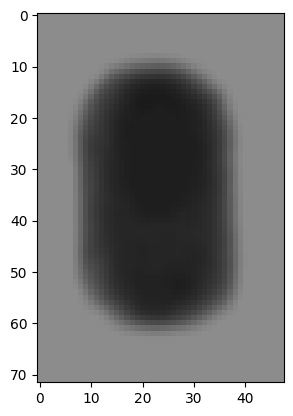

(72, 48, 3)


In [14]:
import matplotlib.pyplot as plt
import cv2

# 이미지 불러오기
image = cv2.imread(simulation_depth_paths[0])

# OpenCV는 BGR 채널 순서를 사용하지만, matplotlib은 RGB를 사용하므로 변환해야 합니다.
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 이미지 표시
plt.imshow(image_rgb)
plt.show()
print(image_rgb.shape)

In [15]:
train_sem_paths = simulation_sem_paths[:int(data_len*0.8)]
train_depth_paths = simulation_depth_paths[:int(data_len*0.8)]

val_sem_paths = simulation_sem_paths[int(data_len*0.8):]
val_depth_paths = simulation_depth_paths[int(data_len*0.8):]

In [16]:
print('train, val 각각 개수 출력')
print('train_sem_paths: ', len(train_sem_paths))
print('train_depth_paths: ', len(train_depth_paths))
print('val_sem_paths: ', len(val_sem_paths))
print('val_depth_pathㅠs: ', len(val_depth_paths))

train, val 각각 개수 출력
train_sem_paths:  138643
train_depth_paths:  138643
val_sem_paths:  34661
val_depth_pathㅠs:  34661


In [17]:
import cv2
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, sem_path_list, depth_path_list):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list

    def __getitem__(self, index):
        # semantic image
        sem_path = self.sem_path_list[index]
        sem_img = cv2.imread(sem_path)
        sem_img = sem_img.transpose(2, 0, 1)  # (H, W, C) to (C, H, W)
        sem_img = sem_img / 255.0

        # depth image
        if self.depth_path_list is not None:
            depth_path = self.depth_path_list[index]
            depth_img = cv2.imread(depth_path)
            depth_img = depth_img.transpose(2, 0, 1)  # (H, W, C) to (C, H, W)
            depth_img = depth_img / 255.0

            # Resize to (256, 256)
            sem_img = resize_image(sem_img, 256, 256)
            depth_img = resize_image(depth_img, 256, 256)

            return {"A": torch.Tensor(depth_img), "B": torch.Tensor(sem_img)}
        else:
            img_name = sem_path.split('/')[-1]

            # Resize to (256, 256)
            sem_img = resize_image(sem_img, 256, 256)

            return {"A": torch.Tensor(sem_img), "B": img_name}

    def __len__(self):
        return len(self.sem_path_list)

def resize_image(image, target_height, target_width):
    _, height, width = image.shape

    # Calculate scale factors for resizing
    scale_height = target_height / height
    scale_width = target_width / width

    # Resize the image using interpolation
    resized_image = cv2.resize(image.transpose(1, 2, 0), (target_width, target_height), interpolation=cv2.INTER_LINEAR)

    return resized_image.transpose(2, 0, 1)


In [18]:
train_dataset = CustomDataset(train_sem_paths, train_depth_paths)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

val_dataset = CustomDataset(val_sem_paths, val_depth_paths)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [19]:
len(train_dataset), len(val_dataset)

(138643, 34661)

In [20]:
print(train_dataset[0]["A"].shape)
print(train_dataset[0]["B"].shape)
#딕셔너리 형태로 반환되었음

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


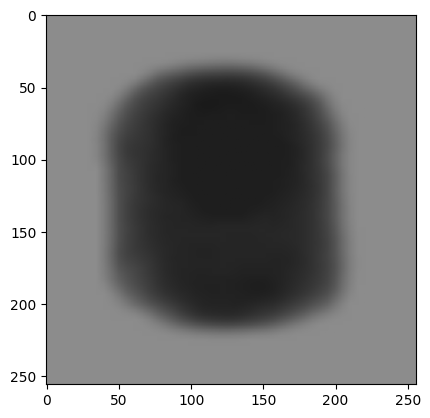

In [21]:
import matplotlib.pyplot as plt

# 코드 수정 후 실행
plt.imshow(train_dataset[0]["A"].permute(1, 2, 0))
plt.show()


In [22]:
# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x


# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)
        

In [23]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
generator = GeneratorUNet()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.cuda()
criterion_pixelwise.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [24]:
from torchsummary import summary

summary_generator = str(summary(generator, (3 ,256,256), device='cuda'))

print(summary_generator)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
          UNetDown-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
    InstanceNorm2d-5          [-1, 128, 64, 64]               0
         LeakyReLU-6          [-1, 128, 64, 64]               0
          UNetDown-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
        LeakyReLU-10          [-1, 256, 32, 32]               0
         UNetDown-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,152
   InstanceNorm2d-13          [-1, 512, 16, 16]               0
        LeakyReLU-14          [-1, 512,

In [25]:
import time

n_epochs = 50 # 학습의 횟수(epoch) 설정
sample_interval = 1000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

# 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
lambda_pixel = 100

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_loader):
        # 모델의 입력(input) 데이터 불러오기
        real_A = batch["B"].cuda()
        real_B = batch["A"].cuda()

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
        real = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0) # 가짜(fake): 0

        """ 생성자(generator)를 학습. """
        optimizer_G.zero_grad()

        # 이미지 생성
        fake_B = generator(real_A)

        # 생성자(generator)의 손실(loss) 값 계산
        loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)

        # 픽셀 단위(pixel-wise) L1 손실 값 계산
        loss_pixel = criterion_pixelwise(fake_B, real_B) 

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
        loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
        loss_D = (loss_real + loss_fake) / 2

        # 판별자(discriminator) 업데이트
        loss_D.backward()
        optimizer_D.step()

        done = epoch * len(train_loader) + i
        if done % sample_interval == 0:
            imgs = next(iter(val_loader)) # 10개의 이미지를 추출해 생성
            real_A = imgs["B"].cuda()
            real_B = imgs["A"].cuda()
            fake_B = generator(real_A)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {loss_D.item():.6f}] [G pixel loss: {loss_pixel.item():.6f}, adv loss: {loss_GAN.item()}] [Elapsed time: {time.time() - start_time:.2f}s]")

OutOfMemoryError: ignored